Mean of Erosion Volsum over count: -0.6406693377924527
Standard Deviation of Erosion Volsum over count: 0.38493456820297733
Mean Squared Error: 0.12885478243849033


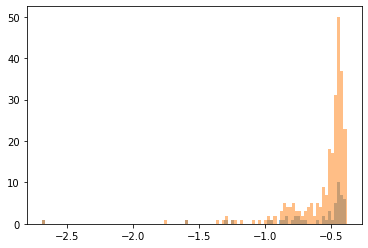

In [13]:
import RF_utils as rfut
from RF_feature_importance import evaluate_model_with_shap, evaluate_feature_with_shap  # Assuming SHAP evaluation is defined here
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.inspection import plot_partial_dependence
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import pandas as pd

# Load your data (modify this part with real data loading)
csv_fn = r"Y:\ATD\GIS\East_Troublesome\Watershed Statistical Analysis\Watershed Stats\Hillslopes\Stream Clipped Hillslopes Pruned\Hillslope_Stats_Combined 050224.csv"
variables_to_exclude = ['ID', 'Erosion mean', "Category",	"OBJECTID", "Deposition mean",	"Deposition stdev",	"Erosion stdev", "Watershed",
                    "Deposition mean Masked",	"Deposition stdev Masked",	"Erosion mean Masked",	"Erosion stdev Masked", 'Erosion Volsum Masked',	
                    'Erosion Volsum Masked Count',	'Erosion Volsum over count', 'Deposition Volsum Masked',	'Deposition Volsum Masked Count',  
                    'perimeter', "width", "length", "area",
                    "Curvature", "width_over_length",
                    # "Aspect Mean", "Aspect std",   "dummy", "% Bare Earth", ,  "Mulch Coverage %"
                    # "Slope Mean", "Slope std",  "Max Int 60 min", "Accumulated Precipitation",
                    # "Terrain Ruggedness Index", "Flow Accumulation", "dNBR Mean",
                    ] #
# #8                % Bare Earth        1
# 15   Terrain Ruggedness Index        1
# 5                   Slope std        1
# 16          Flow Accumulation        1
# 10  Accumulated Precipitation        1
# 9              Max Int 60 min        2
y_field = 'Erosion Volsum over count'
watershed_values = None

def load_data(file_path, exclude_vars, y_var):
    # Load the dataset from a CSV file
    data = pd.read_csv(file_path)
    
    # Drop rows where Erosion Volsum Masked Count is less than 10
    data = data[data['Erosion Volsum Masked Count'] >= 1]
    
    # Select features and target variable, excluding specified columns
    X = data.drop(columns=exclude_vars)
    y = data[y_var].dropna()  # Initially drop rows where the target variable is NaN
    y = y[y <= -0.196]
    # Align X and y to ensure they have the same index after initial cleaning
    X = X.loc[y.index]
    
    X = X.dropna(axis=1)  # Drop any columns with NaN values
    y = y.loc[X.index]  # Align y to the remaining rows in X
    # Convert categorical columns to dummy variables
    X = pd.get_dummies(X)
    
    # Drop any rows with NaN values across the dataset after transformations
    combined = X.join(y.rename('target'))
    combined = combined.dropna()  # This will remove rows with any NaN values in X or y

    # Separate the features and target variable again after cleaning
    X = combined.drop(columns=['target'])
    y = combined['target']
    if X.isnull().values.any() or y.isnull().values.any():
        raise ValueError("NaN values found in the features after data preparation")
    if X.isna().values.any() or y.isna().values.any():
        raise ValueError("NA values found in the features after data preparation")
    return X, y


# Example of calling load_data and handling exceptions
try:
    X, y = load_data(csv_fn, variables_to_exclude, y_field)
except ValueError as e:
    print(f"Error in data preparation: {e}")


#get log transform of X and y
#create a new column in X called dummy that is random noise
# Split the data into training and test sets
#rfut.tune_and_evaluate_model(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train the model
model = RandomForestRegressor(n_estimators=350, max_depth=18, min_samples_split=5)
model.fit(X_train, y_train)
print(f"Mean of {y_field}: {y_test.mean()}")
print(f"Standard Deviation of {y_field}: {y_test.std()}")
mse, predictions = rfut.evaluate_model(model, X_test, y_test)
# Evaluate the model with SHAP
#evaluate_model_with_shap(model, X_train, X_test)

#make a data frame from y_test and predictions
df = pd.DataFrame(y_test)
#name the column y_field
df[y_field] = y_test
df['predictions'] = predictions
df_og = pd.DataFrame(y)
#plot histogram of y_test and y
plt.hist(df[y_field], bins=100, alpha=0.5, label='y_test')
plt.hist(y, bins=100, alpha=0.5, label='y')
plt.show()


Mean Squared Error: 0.053934169259758045
Mean Squared Error: 0.11126241183537006
Mean Squared Error: 0.017972324694672505
Mean Squared Error: 0.03736208896782226
Mean Squared Error: 0.04440346870324952
Average Score: 0.13498563262308802
Average R^2: 0.16557060980532246
Average MSE: 0.05298689269217448
Feature Importance


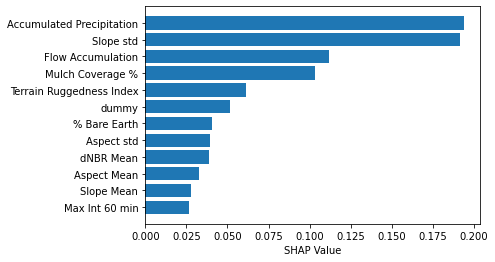

In [14]:
# get score of best_model
# Set up cross-validation
from sklearn.model_selection import KFold, RandomizedSearchCV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
shap_DICT ={}
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    
    mse, predictions = rfut.evaluate_model(model, X_test, y_test)
    predictions_series = pd.Series(predictions, index=y_test.index)
    R2 = y_test.corr(predictions_series)**2

    results.append({'MSE': mse, 'R2': R2, 'score': model.score(X_test, y_test)})
    RANKED_shap, _ = evaluate_model_with_shap(model, X_train, X_test, plot =False)
    for key in RANKED_shap['Feature']:
        if key in shap_DICT:
            shap_DICT[key] += RANKED_shap['SHAP Importance'][RANKED_shap['Feature'] == key].values[0]
        else:
            shap_DICT[key] = RANKED_shap['SHAP Importance'][RANKED_shap['Feature'] == key].values[0]
# Print summary of results

mean_R2 = np.mean([r['R2'] for r in results])
mean_MSE = np.mean([r['MSE'] for r in results])
mean_score = np.mean([r['score'] for r in results])
print(f"Average Score: {mean_score}")
print(f"Average R^2: {mean_R2}")
print(f"Average MSE: {mean_MSE}")
print("Feature Importance")
#plot shap values as a bar chart with feature names on the y axis with the most important feature at the top
#convert shap_DICT to a dataframe
shap_df = pd.DataFrame(shap_DICT.items(), columns = ['Feature', 'SHAP Importance'])
shap_df = shap_df.sort_values(by = 'SHAP Importance', ascending = True)
shap_df = shap_df.reset_index(drop = True)
#plot the top 10 features
plt.barh(shap_df['Feature'], shap_df['SHAP Importance'])
plt.xlabel('SHAP Value')
plt.show()


In [17]:
#write X and y to a csv
df = X.join(y)
df.to_csv("Hillslope_Stats_Combined 050224_cleaned.csv", index = False)

Correlation: 0.4345470701476782
Number of training samples: 210
Number of testing samples: 52


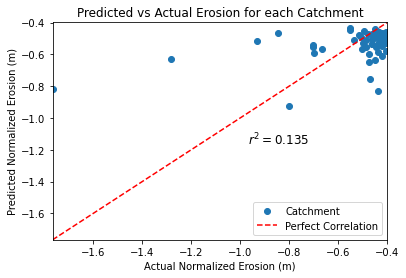

In [15]:
#make a data frame from y_test and predictions
df = pd.DataFrame(y_test)
#name the column y_field
df[y_field] = y_test
df['predictions'] = predictions
#plot the predictions vs y_test so x and y are the same

#get the correlation between the predictions and y_test
correlation = df[y_field].corr(df['predictions'])
print(f"Correlation: {correlation}")

print(f"Number of training samples: {len(y_train)}")
print(f"Number of testing samples: {len(y_test)}")

plt.scatter(df[y_field], df['predictions'])
plt.xlabel('Actual Normalized Erosion (m)')
plt.ylabel('Predicted Normalized Erosion (m)')
#set axis to be the same bounds
plt.xlim(min(df[y_field]), max(df[y_field]))
plt.ylim(min(df[y_field]), max(df[y_field]))
#plot a perfect correlation line
plt.plot([min(df[y_field]), max(df[y_field])], [min(df[y_field]), max(df[y_field])], color='red', linestyle='--')
plt.title('Predicted vs Actual Erosion for each Catchment')

#make r^2 with the exponent
# Ensure you have defined the appropriate y_field in your DataFrame
y_min = min(df[y_field])
y_max = max(df[y_field])
x_min = min(df['predictions'])
x_max = max(df['predictions'])
x_position = x_min +x_min* 0.1 * (x_max - x_min)
y_position = y_max - 0.5 * (y_max - y_min)
plt.text(x_position, y_position, r"$r^2=    {:.3f}$".format(mean_score), fontsize=12, fontweight='bold',
         verticalalignment='top', horizontalalignment='left', backgroundcolor='white', color='black')

plt.legend(['Catchment', 'Perfect Correlation'], loc='lower right')

plt.show()

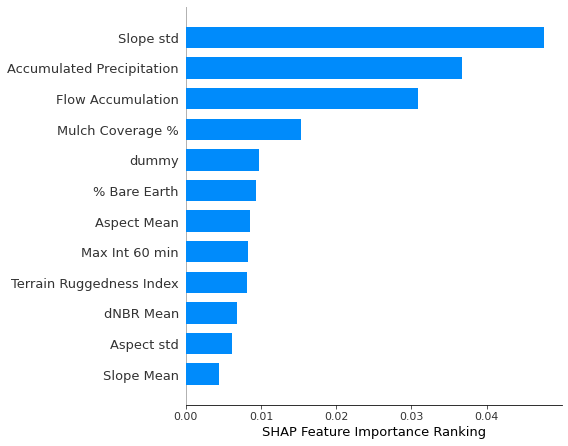

NameError: name 'recursive_feature_elimination' is not defined

In [16]:
feature_list, shap_plot = evaluate_model_with_shap(model, X_train, X_test)
display(shap_plot)
features = recursive_feature_elimination(model, X, y, n_features_to_select=2)
print(f"Recursive feature elimination: \n {features}")

In [ ]:
print([r['score'] for r in results])

[0.12247964250992438, 0.18505130295230643, 0.01947906291973811, 0.2784002005378554, 0.14542269176471956]


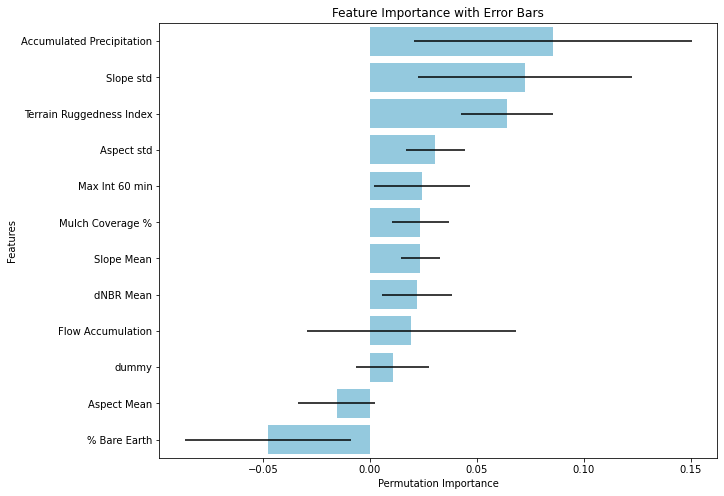

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.inspection import permutation_importance

# Assuming best_model, X_test, y_test are already defined
# Calculate permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Prepare the data for plotting
importances = perm_importance.importances_mean[perm_importance.importances_mean.argsort()]
std = perm_importance.importances_std[perm_importance.importances_mean.argsort()]
features = X_test.columns[perm_importance.importances_mean.argsort()]

# Reverse the order so the most important feature is at the top
importance_data = pd.DataFrame({
    'Features': features[::-1],
    'Importances': importances[::-1],
    'Std': std[::-1]
})

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Importances', y='Features', data=importance_data, xerr=importance_data['Std'], color = 'skyblue')

plt.xlabel('Permutation Importance')
plt.title('Feature Importance with Error Bars')
plt.show()

Mean Squared Error: 0.07809881912309467


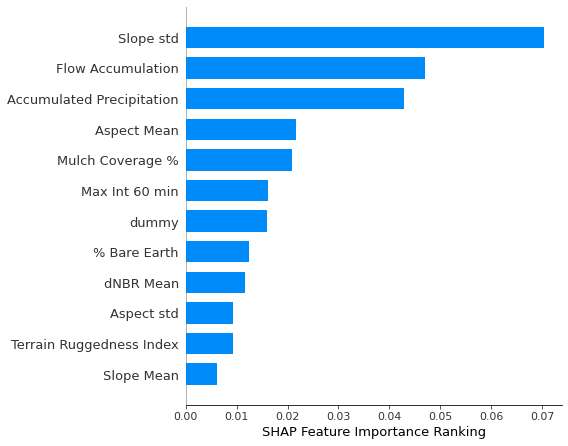

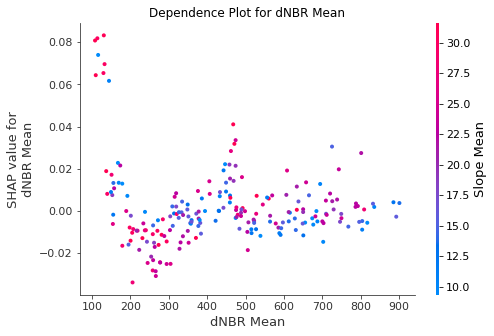

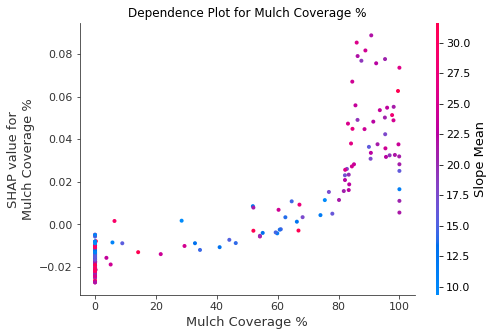

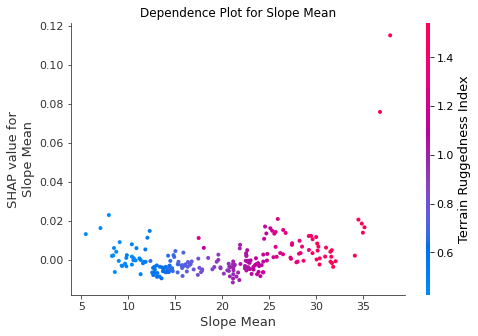

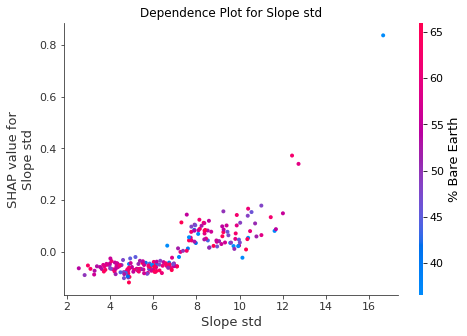

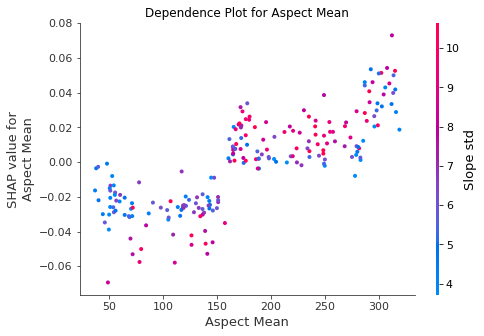

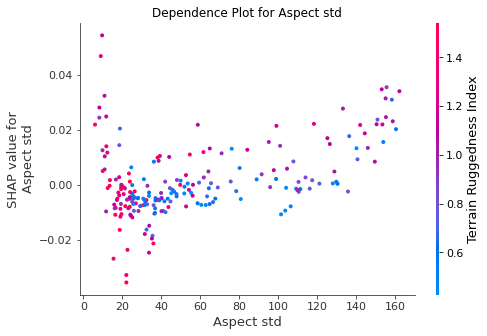

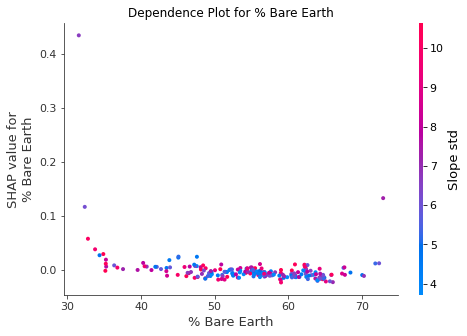

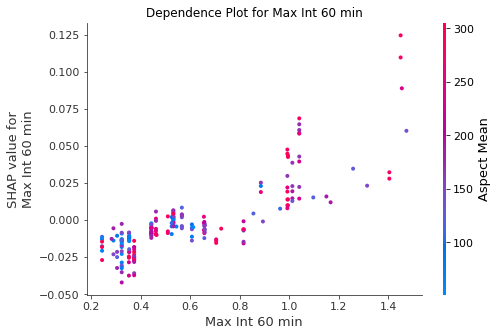

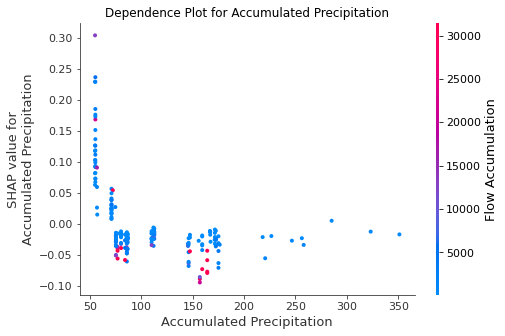

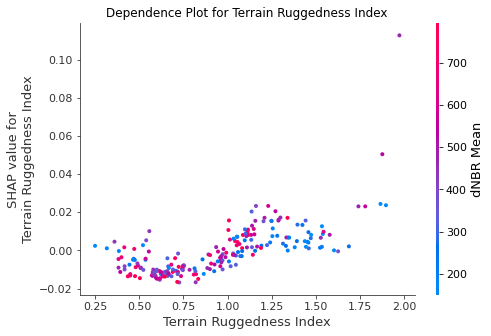

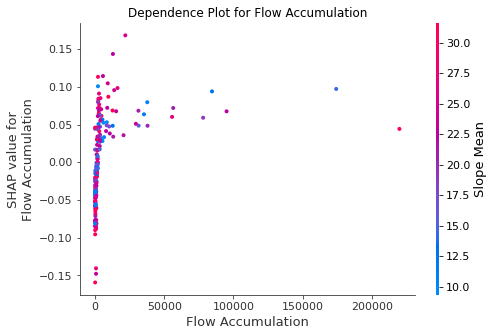

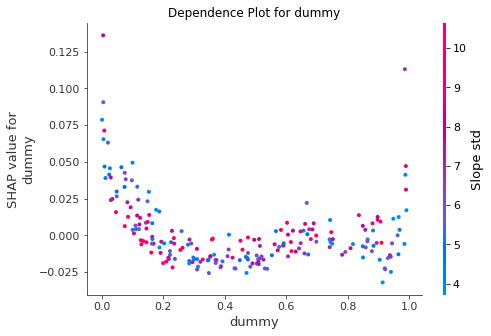

In [ ]:

model = RandomForestRegressor(n_estimators=350, max_depth=18, min_samples_split=5, random_state=42)
model.fit(X_train, y_train)

rfut.evaluate_model(model, X_test, y_test)
# Evaluate the model with SHAP
evaluate_model_with_shap(model, X_train, X_test)
# get feature labels
feature_labels = X.columns

for feature in feature_labels:
    # Create a pdp plot for each feature
    evaluate_feature_with_shap(model, X_train, X_test, feature)
    #plt.show()



In [ ]:
features = recursive_feature_elimination(X, y, n_features_to_select=5)

# Record the top 5 features
top_features = features['Feature'].values[:5]

TypeError: recursive_feature_elimination() missing 1 required positional argument: 'y'

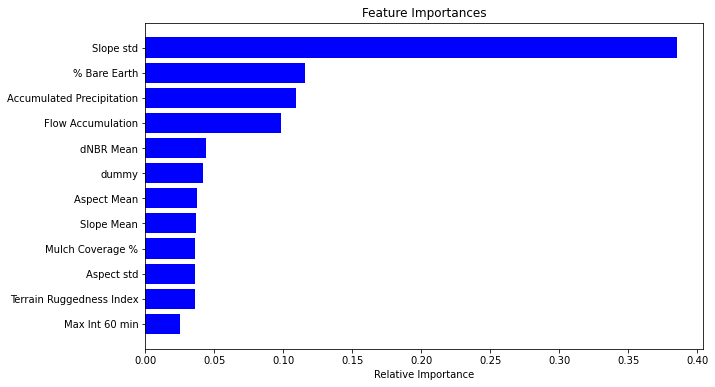

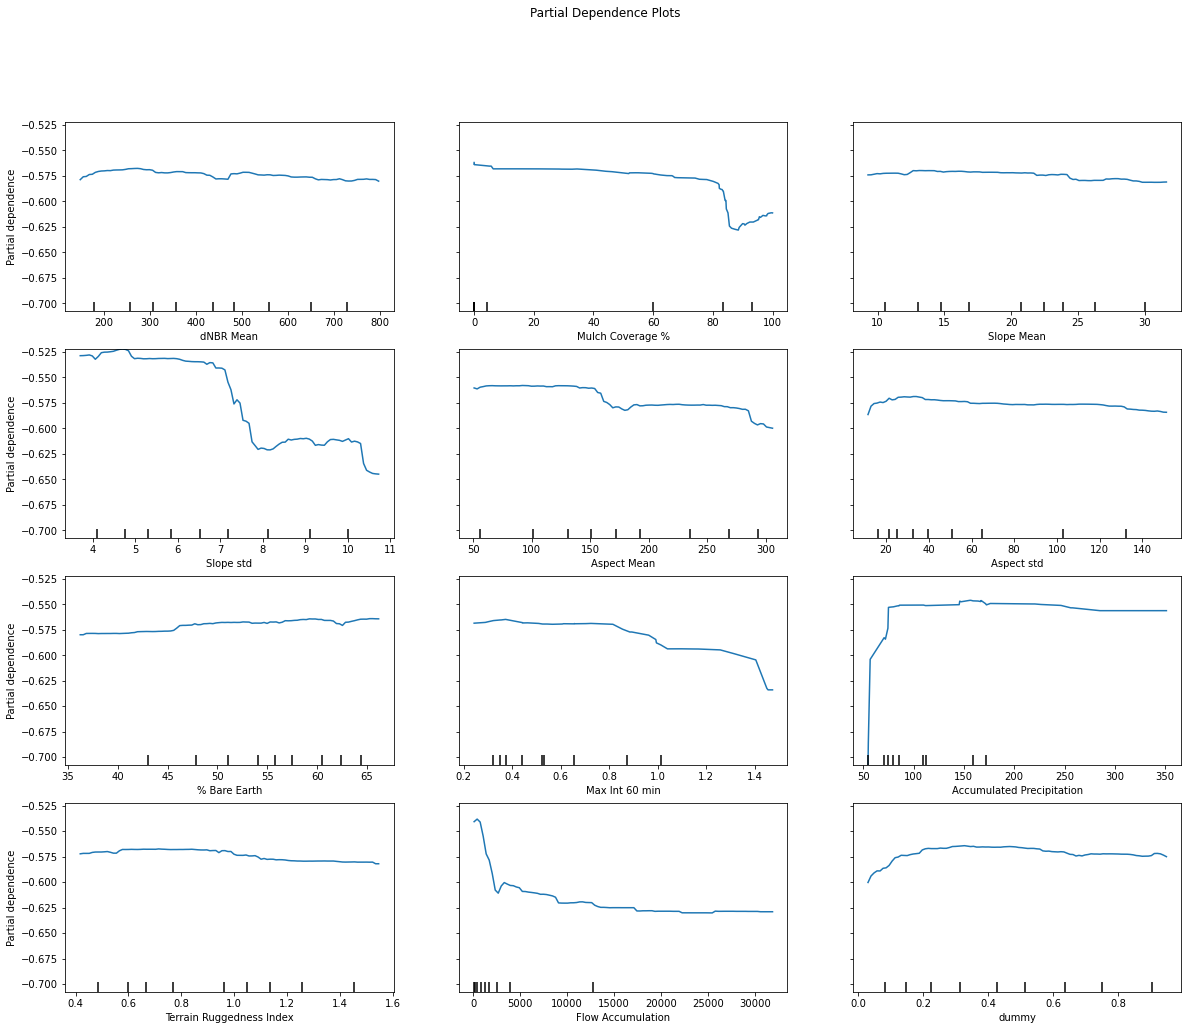

In [ ]:
rfut.plot_feature_importances(model, X.columns)

feature_list = range(0, len(X.columns))
rfut.partial_dependence_plots(model, X_train, feature_list)

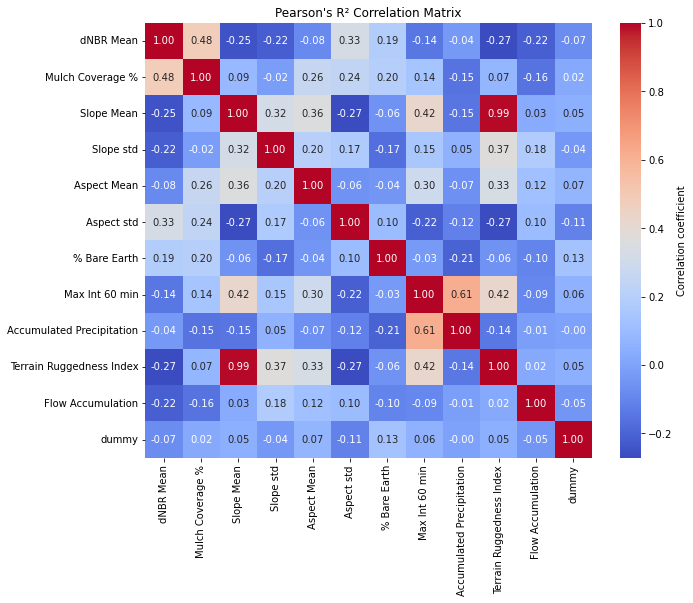

dNBR Mean  Mulch Coverage %  Slope Mean  Slope std  \
dNBR Mean                   1.000000          0.480539   -0.247858  -0.216088   
Mulch Coverage %            0.480539          1.000000    0.090826  -0.021998   
Slope Mean                 -0.247858          0.090826    1.000000   0.319424   
Slope std                  -0.216088         -0.021998    0.319424   1.000000   
Aspect Mean                -0.084385          0.262806    0.358653   0.201541   
Aspect std                  0.328112          0.242832   -0.270645   0.172646   
% Bare Earth                0.190319          0.198028   -0.056898  -0.168345   
Max Int 60 min             -0.142840          0.139319    0.420484   0.150839   
Accumulated Precipitation  -0.036267         -0.154772   -0.149729   0.054402   
Terrain Ruggedness Index   -0.266080          0.072141    0.991479   0.373630   
Flow Accumulation          -0.215930         -0.155822    0.029065   0.177565   
dummy                      -0.074138          0.024208    0.048677  -0.039782   

                           Aspect Mean  Aspect std  % Bare Earth  \
dNBR Mean                    -0.084385    0.328112      0.190319   
Mulch Coverage %              0.262806    0.242832      0.198028   
Slope Mean                    0.358653   -0.270645     -0.056898   
Slope std                     0.201541    0.172646     -0.168345   
Aspect Mean                   1.000000   -0.058792     -0.043696   
Aspect std                   -0.058792    1.000000      0.099787   
% Bare Earth                 -0.043696    0.099787      1.000000   
Max Int 60 min                0.295111   -0.215102     -0.030543   
Accumulated Precipitation    -0.065911   -0.115700     -0.205742   
Terrain Ruggedness Index      0.333483   -0.269037     -0.056736   
Flow Accumulation             0.121382    0.098680     -0.103372   
dummy                         0.069190   -0.107773      0.130215   

                           Max Int 60 min  Accumulated Precipitation  \
dNBR Mean                       -0.142840                  -0.036267   
Mulch Coverage %                 0.139319                  -0.154772   
Slope Mean                       0.420484                  -0.149729   
Slope std                        0.150839                   0.054402   
Aspect Mean                      0.295111                  -0.065911   
Aspect std                      -0.215102                  -0.115700   
% Bare Earth                    -0.030543                  -0.205742   
Max Int 60 min                   1.000000                   0.614626   
Accumulated Precipitation        0.614626                   1.000000   
Terrain Ruggedness Index         0.421364                  -0.136750   
Flow Accumulation               -0.092186                  -0.013921   
dummy                            0.055065                  -0.003500   

                           Terrain Ruggedness Index  Flow Accumulation  \
dNBR Mean                                 -0.266080          -0.215930   
Mulch Coverage %                           0.072141          -0.155822   
Slope Mean                                 0.991479           0.029065   
Slope std                                  0.373630           0.177565   
Aspect Mean                                0.333483           0.121382   
Aspect std                                -0.269037           0.098680   
% Bare Earth                              -0.056736          -0.103372   
Max Int 60 min                             0.421364          -0.092186   
Accumulated Precipitation                 -0.136750          -0.013921   
Terrain Ruggedness Index                   1.000000           0.024485   
Flow Accumulation                          0.024485           1.000000   
dummy                                      0.051326          -0.045541   

                              dummy  
dNBR Mean                 -0.074138  
Mulch Coverage %           0.024208  
Slope Mean                 0.048677  
Slope std                 -0.039782 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_matrix_table(features_df):
    """
    Calculate and display a correlation matrix with Pearson's R^2 for all features.

    Parameters:
    - features_df (pd.DataFrame): DataFrame containing all the features.

    Returns:
    - Displays a heatmap of the correlation matrix.
    """
    # Calculate the Pearson correlation matrix
    corr_matrix = features_df.corr()
    
    # Create a heatmap to visualize the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation coefficient'})
    plt.title("Pearson's R² Correlation Matrix")
    plt.show()

    return corr_matrix

correlation_matrix_table(X_train)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

def feature_impact_analysis(X, y, random_state=42):
    """
    Evaluate the impact of each feature on the RandomForestRegressor model performance.
    Both R^2 and MSE are calculated for each feature removal to assess impact.

    Args:
    X (DataFrame): The feature matrix.
    y (Series): The target variable.
    random_state (int): Seed for the random number generator for reproducibility.

    Returns:
    DataFrame: A DataFrame with each feature and the resulting R^2 and MSE when that feature is removed.
    """
    results = []
    original_features = X.columns.tolist()
    # Split the data to ensure fair evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    
    # Train a model with all features to establish baseline performance
    model = RandomForestRegressor(random_state=random_state)
    model.fit(X_train, y_train)
    baseline_r2 = model.score(X_test, y_test)
    predictions = model.predict(X_test)
    baseline_mse = mean_squared_error(y_test, predictions)
    
    # Iterate over each feature to be removed and retrain the model
    for feature in original_features:
        X_train_reduced = X_train.drop(columns=[feature])
        X_test_reduced = X_test.drop(columns=[feature])
        
        model = RandomForestRegressor(random_state=random_state)
        model.fit(X_train_reduced, y_train)
        reduced_predictions = model.predict(X_test_reduced)
        
        r2_score_reduced = model.score(X_test_reduced, y_test)
        mse_reduced = mean_squared_error(y_test, reduced_predictions)
        
        results.append({'Feature': feature,
                        'R^2 Score': r2_score_reduced,
                        'R^2 Drop': baseline_r2 - r2_score_reduced,
                        'MSE': mse_reduced,
                        'MSE Increase': mse_reduced - baseline_mse})
    
    return pd.DataFrame(results).sort_values(by='MSE Increase', ascending=False)

# Assuming X and y are defined as your feature set and target variable respectively
impact_df = feature_impact_analysis(X, y)
print(impact_df)


                      Feature  R^2 Score  R^2 Drop       MSE  MSE Increase
3                   Slope std  -0.096405  0.259501  0.052221      0.012360
8   Accumulated Precipitation   0.042517  0.120579  0.045604      0.005743
10          Flow Accumulation   0.049023  0.114073  0.045294      0.005433
2                  Slope Mean   0.144389  0.018707  0.040752      0.000891
11                      dummy   0.150146  0.012950  0.040478      0.000617
6                % Bare Earth   0.151408  0.011688  0.040418      0.000557
5                  Aspect std   0.154394  0.008702  0.040275      0.000414
7              Max Int 60 min   0.162768  0.000328  0.039876      0.000016
4                 Aspect Mean   0.176164 -0.013068  0.039238     -0.000622
0                   dNBR Mean   0.179713 -0.016617  0.039069     -0.000791
9    Terrain Ruggedness Index   0.193500 -0.030404  0.038413     -0.001448
1            Mulch Coverage %   0.206844 -0.043748  0.037777     -0.002084
